<a href="https://colab.research.google.com/github/dcastf01/creating_adversarial_images/blob/main/Create_adversarial_images_with_differents_models_at_same_time.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Introduccion

Notebook para la creación de imágenes adversariales para un estudio que se está realizando en el Vrain

Es útil usar el siguiente video para la creación de nuestras imagenes adversariales

El modelo que se va a utilizar es el Nasnet

In [ ]:
import os, sys, math
import numpy as np
from matplotlib import pyplot as plt
if 'google.colab' in sys.modules: # Colab-only Tensorflow version selector
  %tensorflow_version 2.x
  
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE
# Detect hardware
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu = None
  gpus = tf.config.experimental.list_logical_devices("GPU")
    
# Select appropriate distribution strategy for hardware
if tpu:
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)
  print('Running on TPU ', tpu.master())  
elif len(gpus) > 0:
  #strategy = tf.distribute.MirroredStrategy(gpus) # this works for 1 to multiple GPUs
  print('Running on ', len(gpus), ' GPU(s) ')
  strategy=tf.distribute.OneDeviceStrategy(gpus[0])
else:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')

# How many accelerators do we have ?
print("Number of accelerators: ", strategy.num_replicas_in_sync)

Tensorflow version 2.4.0
Running on  1  GPU(s) 
Number of accelerators:  1


In [ ]:
!nvidia-smi

Wed Jan 13 14:42:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P0    31W /  70W |    227MiB / 15079MiB |      1%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import requests

def download_file_from_google_drive(id, destination):
    def get_confirm_token(response):
        for key, value in response.cookies.items():
            if key.startswith('download_warning'):
                return value

        return None

    def save_response_content(response, destination):
        CHUNK_SIZE = 32768

        with open(destination, "wb") as f:
            for chunk in response.iter_content(CHUNK_SIZE):
                print(chunk)
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)

    URL = "https://docs.google.com/uc?export=download"
   #URL=" https://docs.google.com/open?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

In [ ]:
%%capture
set_image_to_create_adversarial=True  #@param {type:"boolean"} 

if set_image_to_create_adversarial:
  file_id="1QA2HeOxusHicdbUxg54M8PG2GorB8ukG"
  destination="ILSVRC2012_val_5.zip"
  download_file_from_google_drive(file_id, destination)


label_id="1PKH4QWZe_VCOhu19oOhbV9z-YKrKACO7"
destination_label_id="/content/label.txt"
download_file_from_google_drive(label_id, destination_label_id)

label_real_name="1sxe3eunq5U4EwsHlLaeRmwcnaZjCEcnh"
destination_label_real_name="/content/name_real_label.json"
download_file_from_google_drive(label_real_name, destination_label_real_name)

In [ ]:
%%capture 
!mkdir data
!unzip /content/ILSVRC2012_val_5.zip  -d data

#Define labels

In [ ]:
import json
relation_classid_classname="/content/name_real_label.json"
relation_file_classid="/content/label.txt"
def get_dictionary_with_real_class():
  path_json_real_label=relation_classid_classname #el json es el bueno
  real_class_prev=json.loads(open(path_json_real_label).read())
  real_class=dict()
  for k in real_class_prev:
    real_class[int(k)]=real_class_prev[k][1] #dictionary key:number value:string
  return real_class


def get_all_labels(file_path_map):

  #file_path_map="/content/ILSVRC2012_validation_map_real.txt"
  conjunto_name_and_label = [l.strip() for l in open(file_path_map).readlines()]
  names=list()
  labels=list()
  for conjunto in conjunto_name_and_label:
    names_and_labels=conjunto.split(" ")
    names.append(names_and_labels[0])
    labels.append(names_and_labels[1])
  return dict(zip(names, labels))

def get_idclass_from_filename(filename):
  return int(dictionary_filename_idclass[filename])
def get_nameclass_from_idclass(idclass):
  return dictionary_idclass_nameclass[int(idclass)]


In [ ]:

dictionary_filename_idclass=get_all_labels(relation_file_classid)
dictionary_idclass_nameclass=get_dictionary_with_real_class()

#Create model

Requisito, ambos modelos deben de tener el  mismo tamaño de entrada

In [ ]:
#@title class model necessary to wrap all
class Model:
  def __init__(self,model,result_target:float):
    self.model=model
    self.model_name=model.name
    self.result_target=result_target
    self.type_result=self.get_type_result()

    self.model_predicts_the_correct_class=None
    self.accuracy_in_the_class_of_this_image=None
    self.threshold_target_accuracy_in_the_class_of_this_image=None
    self.is_necessary_continue_modified_because_the_image_target_not_achieve=None

  def get_type_result(self):
    if self.result_target==1:
      return "improving model 100% accuracy"
    elif self.result_target==0:
      return "The model always fail"
    else:
      return "The model is random with a accuracy of {} % ".format(self.result_target*100)
    
  def is_next_iteracion_model_predicts_the_correct_class(self):
      random_number=tf.random.uniform(
            [], minval=0.000001, maxval=1, dtype=tf.dtypes.float32, seed=None, name=None
            )
      if self.result_target-random_number>=0: 

        self.model_predicts_the_correct_class=True
        self.accuracy_in_the_class_of_this_image=0
        self.threshold_target_accuracy_in_the_class_of_this_image=0.95

      else:

        self.model_predicts_the_correct_class=False
        self.accuracy_in_the_class_of_this_image=1
        self.threshold_target_accuracy_in_the_class_of_this_image=0.001

  def predict(self,image):
    self.prediction=self.model(image)

  def update_accuracy_in_the_class_of_this_image(self,target_class):
    self.accuracy_in_the_class_of_this_image=self.prediction[0][target_class].numpy()


In [ ]:
#@title choosing models to use and target result
include_MobileNet = True #@param {type:"boolean"}
result_target_MobileNet=1#@param {type:"slider", min:0, max:1, step:0.1}

include_ResNet50V2 = True #@param {type:"boolean"}
result_target_ResNet50V2=0#@param {type:"slider", min:0, max:1, step:0.1}

include_DenseNet121 = True #@param {type:"boolean"}
result_target_DenseNet121=0.5#@param {type:"slider", min:0, max:1, step:0.1}

models_list_to_experiment=[]

if include_MobileNet:
  Mobilenet=Model(tf.keras.applications.MobileNet(include_top=True,
                                                      weights='imagenet'),
                          result_target_MobileNet
                          )
  models_list_to_experiment.append(Mobilenet)

if include_ResNet50V2:
  ResNet50V2 = Model(tf.keras.applications.ResNet50V2(include_top=True,
                                                      weights='imagenet'),
                          result_target_ResNet50V2
                         )
  models_list_to_experiment.append(ResNet50V2)

if include_DenseNet121:
  DenseNet121=Model(tf.keras.applications.DenseNet121(include_top=True,
                                                      weights='imagenet'),
                          result_target_DenseNet121
                          )
  models_list_to_experiment.append(DenseNet121)


print_summary_of_models=False #@param {type:"boolean"}
if print_summary_of_models:
  for model in models_list_to_experiment:
    print(model.model.summary())

33193984/33188688 [==============================] - 0s 0us/step


#create Dataset

In [ ]:
#@title Creating dataset
import pathlib
idxsubset=1 #@param {type:"slider", min:1, max:5, step:1}
examples=1000 #@param integer
inpath="/content/data"
outpath_base="result_adversarial"
# Imagenet_root=pathlib.Path(inpath)
# list_ds = tf.data.Dataset.list_files(str(Imagenet_root/'*'))
imgurls= !ls -1 "{inpath}"
imgurls=[correct_format for correct_format in imgurls ]
n_total=len(imgurls)
idx_initial=examples*(idxsubset-1)
idx_final=examples*idxsubset
subset_image=imgurls[idx_initial:idx_final]
n_subset=len(subset_image)
IMG_WIDTH=models_list_to_experiment[0].model.input.shape[1]
IMG_HEIGHT =models_list_to_experiment[0].model.input.shape[2]

assert all([(model.model.input.shape[1] ==IMG_WIDTH) and(model.model.input.shape[2]==IMG_HEIGHT)  for model in models_list_to_experiment])


preproces_input=tf.keras.applications.imagenet_utils.preprocess_input #tensorflow trabaja entre -1 y 1
decode_predictions=tf.keras.applications.imagenet_utils.decode_predictions

def get_image(filepath):
  image=tf.io.read_file(filepath,)
  image=tf.io.read_file("data/"+filepath,)
  image = tf.cast(tf.io.decode_jpeg(image,channels=3),tf.float32)
  images_preproces=preproces_input(image,mode='tf')
  image=tf.image.resize(image,[IMG_WIDTH,IMG_HEIGHT])
  images_preproces=tf.image.resize(images_preproces,[IMG_WIDTH,IMG_HEIGHT])

  return tf.cast(image,tf.float32), images_preproces,filepath

list_ds=tf.data.Dataset.from_tensor_slices(subset_image)

images_original=list_ds.map(get_image,num_parallel_calls=tf.data.experimental.AUTOTUNE)
images_original=images_original.batch(1)

In [ ]:
#@title show original images an predictions of differents model
show_examples = False #@param {type:"boolean"}
number_images_to_show= 2 #@param integer
if show_examples:
  for model in models_list_to_experiment:
    for original_images,preprocess_image,filepath in images_original.take(number_images_to_show): 
      print(model.model_name)
      plt.imshow(tf.cast(original_images[0],tf.int32))
      predicts=model.model.predict(preprocess_image)
      print("model to worse",decode_predictions(predicts))


In [ ]:
#@title Functions necessary


def is_necesary_continue_because_not_all_accuracy_are_achieve_for_the_purpose_of_the_model_in_this_image(models):
  aux_list_bool=[]
  for model in models:
    # print(model.model_name)
    if model.model_predicts_the_correct_class:
      aux_list_bool.append(model.accuracy_in_the_class_of_this_image <model.threshold_target_accuracy_in_the_class_of_this_image)
    else: 
      aux_list_bool.append(model.accuracy_in_the_class_of_this_image >model.threshold_target_accuracy_in_the_class_of_this_image)
  return any(aux_list_bool)         

def data_from_original_image(filename):
  original_idclass=get_idclass_from_filename(filename)
  original_nameclass=get_nameclass_from_idclass(original_idclass)

  return original_nameclass,original_idclass


"""Función de perdida, que intentará maximizar que el modelo a mejorar siempre acierte y que el modelo a fallar siempre falle se le ha añadido un hiperparametro para ver si aumentaba la velocidad de la derivada"""

  # loss_object = tf.keras.losses.CategoricalCrossentropy()
loss_object = tf.keras.losses.BinaryCrossentropy()
# loss_object=tf.keras.losses.MeanAbsoluteError()


def function_loss(target_class,models):
  
  loss=0
  for model in models:
    print(model.model_name)
    prediction= tf.expand_dims( model.prediction[0][target_class],0)-0.1
    print(prediction)
    if model.model_predicts_the_correct_class:
     
      target_tensor = tf.constant([1])
      hiperparameter=1

    else:
      target_tensor = tf.constant([0])
      hiperparameter=1.2
    loss_model=loss_object(target_tensor,prediction)*hiperparameter
    print(loss_model)
    loss+=loss_model
  print("suma",loss)
  return loss
     

In [ ]:
loss = function_loss(original_idclass, models_list_to_experiment)
loss

mobilenet_1.00_224
tf.Tensor([0.8999729], shape=(1,), dtype=float32)
tf.Tensor(0.100027084, shape=(), dtype=float32)
resnet50v2
tf.Tensor([0.9], shape=(1,), dtype=float32)
tf.Tensor(1.08, shape=(), dtype=float32)
densenet121
tf.Tensor([0.37088677], shape=(1,), dtype=float32)
tf.Tensor(0.44506416, shape=(), dtype=float32)
suma tf.Tensor(1.6250913, shape=(), dtype=float32)


<tf.Tensor: shape=(), dtype=float32, numpy=1.6250913>

In [ ]:
for model in models_list_to_experiment:
  print(model.prediction)

Hago la predicción de la imagen original y luego calculo el coste para mi clase objetivo (en este caso el pañuelo) 

Después calculo la derivada entre el resultado del coste y la imagen original .
 
Y esta diferencia se la añado a la imagen original.
Además le obligó a que el rango de valores de la nueva imagen esté entre uno y menos uno

 Luego vuelvo a ejecutar lo mismo pero en lugar de la predicción de la imagen original lo hago con la imagen original modificada por la derivada. 
Y realizo estos pasos hasta que la predicción 

#Creating adversarial images
Y aquí esta el video donde lo he extraido
https://www.youtube.com/watch?v=-_A_AAxqzCg&ab_channel=DotCSV

mkdir: cannot create directory ‘result_adversarial0.02’: File exists


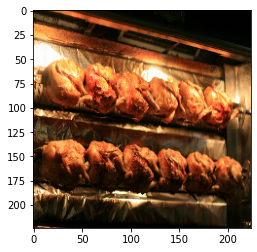

this is the image number: 0
the original class is: rotisserie
mobilenet_1.00_224
tf.Tensor([0.8999729], shape=(1,), dtype=float32)
tf.Tensor(0.100027084, shape=(), dtype=float32)
resnet50v2
tf.Tensor([0.9], shape=(1,), dtype=float32)
tf.Tensor(1.08, shape=(), dtype=float32)
densenet121
tf.Tensor([0.37088677], shape=(1,), dtype=float32)
tf.Tensor(0.6291132, shape=(), dtype=float32)
suma tf.Tensor(1.8091403, shape=(), dtype=float32)
0
accuracy to model mobilenet_1.00_224 in the original class: 99.9973% the target in this image is hit True
accuracy to model resnet50v2 in the original class: 100.0000% the target in this image is hit False
accuracy to model densenet121 in the original class: 47.0887% the target in this image is hit True
mobilenet_1.00_224
tf.Tensor([0.89998174], shape=(1,), dtype=float32)
tf.Tensor(0.10001826, shape=(), dtype=float32)
resnet50v2
tf.Tensor([0.9], shape=(1,), dtype=float32)
tf.Tensor(1.08, shape=(), dtype=float32)
densenet121
tf.Tensor([0.8999971], shape=(1,)

In [ ]:
from IPython.display import clear_output
from google.colab import files
i=0
experiments=[0.75,0.5,0.25,0.1,0.05,0.02,]
experiments_did=[0.75,0.5,0.25,0.1,0.05]
for pert_experiment in experiments:
  if pert_experiment in experiments_did:
    pass
  else:
    outpath=outpath_base+str(pert_experiment)
    filenamezip="adversarial"+str(pert_experiment)+".zip"
    !mkdir $outpath
    filenamelog='log_e_'+str(pert_experiment)+'.txt'
    with open(filenamelog, 'w') as the_file:

      for original_images,preprocess_image,filepath in images_original.skip(162): 
        number_iteration=0

        for model in models_list_to_experiment:
          model.is_next_iteracion_model_predicts_the_correct_class()

        filename=filepath.numpy()[0][-28:].decode()
        
        # original_nameclass,class_confidence_original_img_worse_model,original_idclass=data_from_original_image(filename,model_to_worse)

        original_nameclass,original_idclass=data_from_original_image(filename)

      
        plt.imshow(tf.cast(original_images[0],tf.int32))
        plt.show()
        print("this is the image number:",i)
        adversarial=tf.identity(preprocess_image)
        pert_max=pert_experiment #modificación maxima de los pixeles, como el valor esta normalizado a 1 esto siginifica que es el porcentaje que varia máximo de los pixeles
        max_pert=adversarial+pert_max
        min_pert=adversarial-pert_max
    
        print("the original class is:", original_nameclass)

        while is_necesary_continue_because_not_all_accuracy_are_achieve_for_the_purpose_of_the_model_in_this_image(models_list_to_experiment):
          with tf.GradientTape() as tape:
            tape.watch(adversarial)
            for model in models_list_to_experiment:
              model.predict(adversarial)

            loss = function_loss(original_idclass, models_list_to_experiment)

          if number_iteration%10==0:
            print(number_iteration)
            for model in models_list_to_experiment:
              model.update_accuracy_in_the_class_of_this_image(original_idclass)
              accuracy_to_model=model.accuracy_in_the_class_of_this_image
              is_target_hit=model.model_predicts_the_correct_class
              
              print("accuracy to model {} in the original class: {:.4f}% the target in this image is hit {}".format(model.model_name,accuracy_to_model*100,is_target_hit))
        

          if number_iteration>=1000:
            clear_output()
            print("no convergia")
            print("this is the image number:",i)
            adversarial=tf.identity(preprocess_image)
            number_iteration=0
          else:
          
            number_iteration+=1
            gradient = tape.gradient(loss, adversarial)
            adversarial-=gradient
            adversarial=tf.clip_by_value(adversarial, clip_value_min=min_pert, clip_value_max=max_pert)
            adversarial=tf.clip_by_value(adversarial, clip_value_min=-1, clip_value_max=1)        

        hacked_image=tf.identity(adversarial)
        hacked_image+=1
        hacked_image*=127.5

        pattern_image=original_images-hacked_image

        plt.imshow((tf.cast(hacked_image[0],tf.int32)))
        plt.show()
        new_filename=filename.split(".")[0]+".png"
        filepath=outpath+"/pert_eps_"+str(pert_max)+"_"+new_filename
        tf.keras.preprocessing.image.save_img(
              filepath, tf.cast(hacked_image[0],tf.int32).numpy(), data_format=None, file_format="PNG"
          )
        i+=1
        for model in models_list_to_experiment:

          if model.model_predicts_the_correct_class:
            target="hit"
          else:
            target="false"

          class_confidence_original_img=model.model(preprocess_image)[0][original_idclass].numpy()
          txto=(model.model_name+","+
                target+","+
                filename+","+
                str(class_confidence_original_img)+","+
                str(pert_max)+","+
                
                str(model.accuracy_in_the_class_of_this_image)+","+
                'pert_eps_'+str(pert_max)+'_'+new_filename+"\n"
                )
          the_file.write(txto)
        #el asunto seguira el siguiente formato
        #modelo,objetivo en la iteracion,nombre de archivo,clase original(nombre), fiabilidad inicial,perturbacion,fiabilidad despues de perturbacion, nombre de la nueva imagen

        # print("cost worse model:",cost_to_worse, "lower better")
        # print("cost better model ",cost_to_better, "higher better")
        # original_nameclass,class_confidence_original_img_worse_model,original_idclass=data_from_original_image(filename,model_to_worse)
        # 
        # txto=(filename+","+original_nameclass+","+str(class_confidence_original_img)+","+str(pert_max)+","+adversarial_nameclass+","+str(cost)+ ',pert_eps_'+str(pert_max)+'_'+new_filename+"\n")   
        
        
        if i%2==0:
          clear_output()

    commandfolderextract=outpath+"/*"
    !zip $filenamezip $filenamelog $commandfolderextract
    
    files.download(filenamezip) 


In [ ]:
adversarial

<tf.Tensor: shape=(1, 224, 224, 3), dtype=float32, numpy=
array([[[[-0.9088596 , -0.9048944 , -0.98719245],
         [-0.88397205, -0.89071715, -0.98193115],
         [-0.9505884 , -0.93420833, -0.99392205],
         ...,
         [-0.90939105, -0.8875924 , -0.93838644],
         [-0.8766364 , -0.8260116 , -0.9293673 ],
         [-0.7749523 , -0.74230444, -0.8463836 ]],

        [[-0.8704774 , -0.8765511 , -0.97775614],
         [-0.85634923, -0.86770743, -0.9612586 ],
         [-0.9222144 , -0.9059527 , -0.96682084],
         ...,
         [-0.98790693, -0.9602488 , -0.9761038 ],
         [-0.9754546 , -0.9177784 , -0.9727631 ],
         [-0.92688   , -0.88641965, -0.950148  ]],

        [[-0.79774165, -0.81349176, -0.9199985 ],
         [-0.7633077 , -0.78397804, -0.8946122 ],
         [-0.89064956, -0.89354235, -0.97982347],
         ...,
         [-0.9999981 , -0.9995258 , -0.9962594 ],
         [-0.9859396 , -0.9660129 , -0.9748701 ],
         [-0.9783018 , -0.96837217, -0.9894933

In [ ]:
gradient

In [ ]:
is_necessary_continue_modified_the_image_target_not_achieve

True

In [ ]:
for model in models_list_to_experiment:
  print(model.prediction[0][original_idclass].numpy())

0.9991032
5.0251532e-05
4.057875e-06


In [ ]:
 for model in models_list_to_experiment:
  print(model.accuracy_in_the_class_of_this_image)

0.9991032
5.0251532e-05
4.057875e-06


In [ ]:
plt.imshow((tf.cast(hacked_image[0],tf.int32)))
predicts=model.predict(preproces_input(hacked_image))
print(decode_predictions(predicts))

[[('n02356798', 'fox_squirrel', 1.0), ('n02089973', 'English_foxhound', 1.4410624e-35), ('n15075141', 'toilet_tissue', 0.0), ('n02321529', 'sea_cucumber', 0.0), ('n02395406', 'hog', 0.0)]]


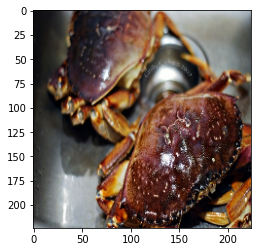

In [ ]:
plt.imshow(tf.cast(original_images[0],tf.int32))
predicts=model_to_worse.predict(preproces_input(original_images))
print(decode_predictions(predicts))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[('n02356798', 'fox_squirrel', 1.0), ('n07613480', 'trifle', 2.9139152e-12), ('n15075141', 'toilet_tissue', 0.0), ('n02317335', 'starfish', 0.0), ('n02391049', 'zebra', 0.0)]]


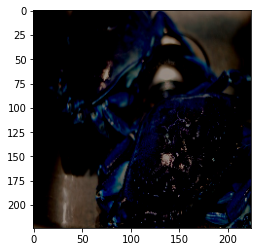

In [ ]:
plt.imshow((tf.cast(preprocess_image[0],tf.int32)))
predicts=model_to_worse.predict(tf.keras.applications.resnet.preprocess_input(preprocess_image))
print(decode_predictions(predicts))